In [1]:
# Imports
import os
import json
import pandas as pd
import timm
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np

from typing import Tuple
from datetime import datetime
from fastai.vision.all import *
from fastai.callback.core import Callback
from fastai.vision.augment import PadMode, Contrast, Saturation

# Data Setup

In [2]:
# List all available models in timm
available_models = timm.list_models()

print("Available models in timm:")
for model in available_models:
    print(model)

Available models in timm:
bat_resnext26ts
beit_base_patch16_224
beit_base_patch16_384
beit_large_patch16_224
beit_large_patch16_384
beit_large_patch16_512
beitv2_base_patch16_224
beitv2_large_patch16_224
botnet26t_256
botnet50ts_256
caformer_b36
caformer_m36
caformer_s18
caformer_s36
cait_m36_384
cait_m48_448
cait_s24_224
cait_s24_384
cait_s36_384
cait_xs24_384
cait_xxs24_224
cait_xxs24_384
cait_xxs36_224
cait_xxs36_384
coat_lite_medium
coat_lite_medium_384
coat_lite_mini
coat_lite_small
coat_lite_tiny
coat_mini
coat_small
coat_tiny
coatnet_0_224
coatnet_0_rw_224
coatnet_1_224
coatnet_1_rw_224
coatnet_2_224
coatnet_2_rw_224
coatnet_3_224
coatnet_3_rw_224
coatnet_4_224
coatnet_5_224
coatnet_bn_0_rw_224
coatnet_nano_cc_224
coatnet_nano_rw_224
coatnet_pico_rw_224
coatnet_rmlp_0_rw_224
coatnet_rmlp_1_rw2_224
coatnet_rmlp_1_rw_224
coatnet_rmlp_2_rw_224
coatnet_rmlp_2_rw_384
coatnet_rmlp_3_rw_224
coatnet_rmlp_nano_rw_224
coatnext_nano_rw_224
convformer_b36
convformer_m36
convformer_s18
convf

In [3]:
# Define training directory and read into a pd dataframe

csv_path = os.path.join('COMP90086_2024_Project_train', 'train.csv')
train_dir = os.path.join('COMP90086_2024_Project_train', 'train')
train_data = pd.read_csv(csv_path)

# Obtain IDs to read the image path
train_data['image_path'] = train_data['id'].apply(lambda x: os.path.join(train_dir, f"{x}.jpg"))

# Target Label of Stable Height
train_data['stable_height'] = train_data['stable_height'].astype(str)

Random Image Path: COMP90086_2024_Project_train\train\132613.jpg
Path Exists: True
Original Image
After Item-Level Transforms
After Batch-Level Transforms


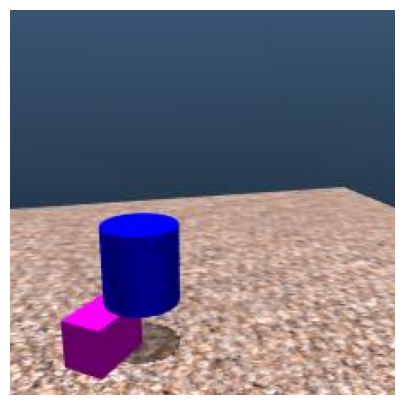

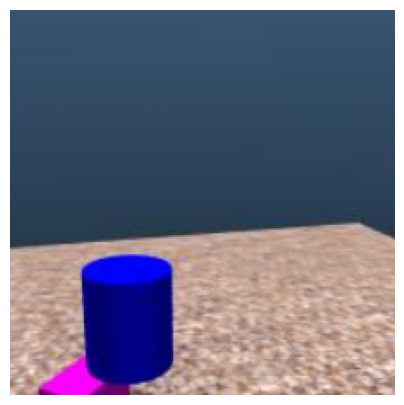

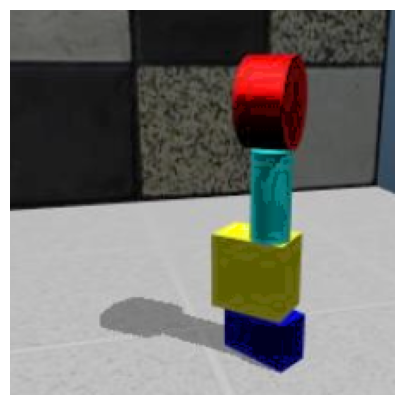

In [4]:
# Obtains images before and after transformations
    # Random images are shown to highlight effects of data augmentation techniques

test_train_data = pd.read_csv(csv_path)

test_train_data['image_path'] = test_train_data['id'].apply(lambda x: f"{x}.jpg")

random_image_path = os.path.join(train_dir, random.choice(test_train_data['image_path'].values))
print(f"Random Image Path: {random_image_path}")
print(f"Path Exists: {os.path.exists(random_image_path)}")

image = PILImage.create(random_image_path)

item_tfms = [RandomResizedCrop(224, min_scale=0.5)]
batch_tfms = [Brightness(), Contrast(), Saturation(), Flip(p=1)]

item_tfms_applied = image
for tfm in item_tfms:
    item_tfms_applied = tfm(item_tfms_applied) 


print("Original Image")
image.show()

print("After Item-Level Transforms")
item_tfms_applied.show()

batch_tfms_pipeline = batch_tfms
dls = ImageDataLoaders.from_df(test_train_data, path=train_dir, fn_col='image_path', label_col='stable_height',
                               item_tfms=item_tfms, batch_tfms=batch_tfms_pipeline, bs=1)

for batch in dls.train:
    print("After Batch-Level Transforms")
    batch[0][0].show() 
    break

# Experimental Pipeline

### Data Loading

In [5]:
# Create a dataloader object to load in data for training and testing purposes

class VisionTransformerDataLoader:
    def __init__(self, train_data, item_tfms=None, batch_tfms=aug_transforms(), bs=8, valid_pct=0.2, num_workers=0):
        """
        Initialize the VisionTransformerDataLoader class.
        
        Args:
        - train_data: The training dataset.
        - item_tfms: Item-level transformations to apply (e.g., Resize, SimpleBlur).
        - batch_tfms: Batch-level transformations to apply (default is aug_transforms()).
        - bs: Batch size (default is 8).
        - valid_pct: Percentage of data to use for validation (default is 0.2).
        - num_workers: Number of workers for data loading (default is 0).
        """
        
        self.train_data = train_data
        self.item_tfms = item_tfms
        self.batch_tfms = batch_tfms
        self.bs = bs
        self.valid_pct = valid_pct
        self.num_workers = num_workers
        self.dls = None
        self.create_dataloader()

    def create_dataloader(self):
        """
        Create and store the DataLoader.
        """
        transformer_db = DataBlock(
            blocks=(ImageBlock, CategoryBlock),  
            get_x=ColReader('image_path'),  
            get_y=ColReader('stable_height'), 
            splitter=RandomSplitter(valid_pct=self.valid_pct),  
            item_tfms=self.item_tfms,            # Apply item-level transforms
            batch_tfms=self.batch_tfms           # Apply batch-level transforms 
        )
        self.dls = transformer_db.dataloaders(self.train_data, bs=self.bs, num_workers=self.num_workers)
        
        # Print few sample images
        self.show_batch()

    def show_batch(self):
        """
        Show a batch of images from the DataLoader.
        """
        if self.dls is not None:
            self.dls.show_batch(max_n=4) 
        else:
            print("DataLoader has not been initialized.")

    def get_dataloader(self):
        """
        Return the DataLoader.
        """
        return self.dls 
       

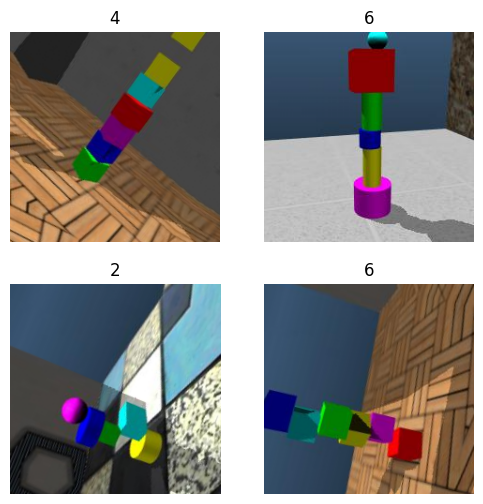

In [6]:
# Verify the dataloader works and is performing the expected transformations

item_tfms = FlipItem(p=1)
batch_tfms = Rotate(max_deg=90, p=0.5)

data_loader = VisionTransformerDataLoader(
    train_data=train_data,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
    bs=8,
    valid_pct=0.2,
    num_workers=0
)


In [7]:
# Create another dataloader for black and white images for additional augmentation training

class VisionTransformerDataLoaderBlackAndWhite:
    def __init__(self, train_data, item_tfms=None, batch_tfms=aug_transforms(), bs=8, valid_pct=0.2, num_workers=0):
        """
        Initialize the VisionTransformerDataLoader class.

        Args:
        - train_data: The training dataset.
        - item_tfms: Item-level transformations to apply (e.g., Resize, SimpleBlur).
        - batch_tfms: Batch-level transformations to apply (default is aug_transforms()).
        - bs: Batch size (default is 8).
        - valid_pct: Percentage of data to use for validation (default is 0.2).
        - num_workers: Number of workers for data loading (default is 0).
        """
        self.train_data = train_data
        self.item_tfms = item_tfms
        self.batch_tfms = batch_tfms
        self.bs = bs
        self.valid_pct = valid_pct
        self.num_workers = num_workers
        self.dls = None
        self.create_dataloader()

    def create_dataloader(self):
        """
        Create and store the DataLoader.
        """
        transformer_db = DataBlock(
            blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), # Image is loaded as black and white instead of color
            get_x=ColReader('image_path'),      
            get_y=ColReader('stable_height'),  
            splitter=RandomSplitter(valid_pct=self.valid_pct), 
            item_tfms=self.item_tfms,            # Apply item-level transforms
            batch_tfms=self.batch_tfms           # Apply batch-level transforms 
        )
        self.dls = transformer_db.dataloaders(self.train_data, bs=self.bs, num_workers=self.num_workers)

        # Print few sample images
        self.show_batch()

    def show_batch(self):
        """
        Show a batch of images from the DataLoader.
        """
        if self.dls is not None:
            self.dls.show_batch(max_n=4) 
        else:
            print("DataLoader has not been initialized.")

    def get_dataloader(self):
        """
        Return the DataLoader.
        """
        return self.dls


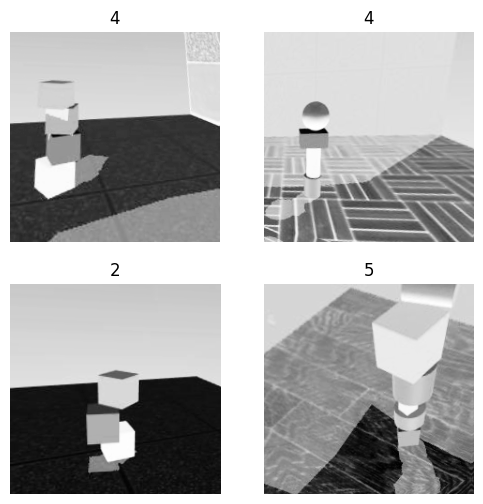

In [8]:
# Verify that the black and white dataloader is working as expected

item_tfms = FlipItem(p=0.5)
batch_tfms = aug_transforms()
    
data_loader = VisionTransformerDataLoaderBlackAndWhite(
    train_data=train_data,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
    bs=8,
    valid_pct=0.2,
    num_workers=0
)

In [9]:
# Save the model every 5 epochs, and at the end of every training
    # Checkpointing so that we can load back to a previous training state if required

class SaveEvery5EpochsCallback(Callback):
    def __init__(self, model_name, transform_name, is_unfrozen=False):
        self.model_name = model_name
        self.transform_name = transform_name
        self.is_unfrozen = is_unfrozen  # Model is sometimes unfrozen, will save model name as a different format if required
    
    def _get_unique_filename(self, filename):
        i = 1
        unique_filename = filename
        while os.path.exists(f"{self.learn.path}/{unique_filename}.pth"):
            unique_filename = f"{filename}_{i}"
            i += 1
        return unique_filename

    def after_epoch(self):
        if (self.epoch + 1) % 5 == 0:
            state = "unfrozen" if self.is_unfrozen else "frozen"
            filename = f"{self.model_name}_{self.transform_name}_{state}_epoch_{self.epoch + 1}"
            filename = self._get_unique_filename(filename) 
            self.learn.save(filename)
            print(f"Model saved at epoch {self.epoch + 1} as {filename}")

    def after_train(self):
        state = "unfrozen" if self.is_unfrozen else "frozen"
        filename = f"{self.model_name}_{self.transform_name}_{state}_final"
        filename = self._get_unique_filename(filename) 
        self.learn.save(filename)
        print(f"Model saved at the end of training as {filename}")

### Model Training Setup

In [10]:
# Create a trainer that loads in the images from the dataloader
class VisionTransformerTrainer:
    def __init__(self, model_name='vit_base_patch16_224', transform_name='basic', dls=None):
        self.model_name = model_name
        self.transform_name = transform_name
        self.learn = None
        self.lr = None
        self.metrics = {}
        self.dls = dls

        if self.dls is None:
            raise Exception("No dataloader provided. Please provide a dataloader when initializing the class.")
        else:
            print("Using provided dataloader.")

    def initialize_model(self, pretrained=True):
        self.model = timm.create_model(self.model_name, pretrained=pretrained, num_classes=self.dls.c)
        self.learn = vision_learner(self.dls, self.model_name, metrics=accuracy, pretrained=pretrained, cbs=CSVLogger())

        if torch.cuda.is_available():
            self.learn.model = self.learn.model.cuda()
            print("CUDA is available. Using GPU for training.")
        else:
            print("CUDA is not available. Using CPU for training.")

    def set_learning_rate(self):
        # Function to automatically find learning rate
        def find_optimal_lr(learner) -> float:
            lr_learn = learner.lr_find(suggest_funcs=(minimum, steep, slide))
            lr_min, lr_steep, lr_slide = lr_learn
            return lr_slide
        
        # Use if we want automatic learning rate
        # self.lr = find_optimal_lr(self.learn)
        
        # Use for manually setting learning rate
        self.lr = 0.001
        print(f"Learning rate set to: {self.lr}")

    def fine_tune(self, epochs=5):
        # Fine-tune trains the entire model all at once
        
        if self.learn is None:
            raise Exception("Model has not been initialized. Please run initialize_model() first.")
        if self.lr is None:
            raise Exception("Learning rate not set. Please set it using set_learning_rate() first.")

        self.learn.add_cb(SaveEvery5EpochsCallback(self.model_name.replace('/', '_'), self.transform_name))
        self.learn.fine_tune(epochs, base_lr=self.lr)
        torch.cuda.empty_cache()
        
    def unfreeze_fit_one_cycle(self, epochs=5):
        # Unfreezes gradually and performs model training
            # Different layers can be commented out as desired
        
        if self.learn is None:
            raise Exception("Model has not been initialized. Please run initialize_model() first.")
        if self.lr is None:
            raise Exception("Learning rate not set. Please set it using set_learning_rate() first.")
        self.learn.add_cb(SaveEvery5EpochsCallback(self.model_name.replace('/', '_'), self.transform_name, is_unfrozen=True))

        # Fits the final layer and fine-tunes it
        self.learn.fit_one_cycle(10, max(self.lr, 2e-2/5))

        # # Freeze up to second to last layer and fit
        # self.learn.freeze_to(-2)
        # # self.learn.fit_one_cycle(10, slice(1e-2/(2.6**4), max(self.lr, 1e-2/5)))
        # self.learn.fit_one_cycle(2, slice(1e-2/(2.6**4), max(self.lr, 1e-2/5)))
        
        # # Freeze up to third to last layer and fit
        # self.learn.freeze_to(-3)
        # self.learn.fit_one_cycle(2, slice(5e-3/(2.6**4), 5e-3))

        # Unfreeze the whole model and fit
        self.learn.unfreeze()
        self.learn.fit_one_cycle(epochs, slice(1e-3/(2.6**4), 1e-3))

        # Clear GPU cache after training
        torch.cuda.empty_cache()

        return

    def save_metrics(self):
        df = self.get_training_metrics()
        df['model_name'] = self.model_name
        df['transform_name'] = self.transform_name
        df['learning_rate'] = self.lr  

        final_accuracy = self.final_accuracy
        final_epoch = self.final_epoch
        total_time = pd.to_timedelta(df['time'].apply(lambda x: f'00:{x}')).sum()

        local_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        df['saved_at'] = local_time

        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        file_name = f"acc{final_accuracy:.3f}_epo{final_epoch:02d}_lr{self.lr:.1e}_tim{total_time.total_seconds():.0f}s_{self.model_name}_{self.transform_name}_{timestamp}.csv"
        file_path = os.path.join('metrics', file_name)

        os.makedirs('metrics', exist_ok=True)
        
        if os.path.exists(file_path):
            counter = 1
            while os.path.exists(file_path):
                file_name = f"acc{final_accuracy:.3f}_epo{final_epoch:02d}_lr{self.lr:.1e}_tim{total_time.total_seconds():.0f}s_{self.model_name}_{self.transform_name}_{timestamp}_{counter}_B&W.csv"
                file_path = os.path.join('metrics', file_name)
                counter += 1
                
        df.to_csv(file_path, index=False)
        print(f"Metrics saved to {file_path}")

    def get_training_metrics(self) -> pd.DataFrame:
        df = self.learn.csv_logger.read_log()
        self.training_metrics = df
        self.final_accuracy = df['accuracy'].iloc[-1]
        self.final_epoch = df['epoch'].iloc[-1]
        return df


### Training Loop

In [12]:
# A loop to automatically apply a mix of item transformations, batch transformations, and different models

# Item-Level Transformations
item_transforms = {
    'none': None,  
    # 'flip': FlipItem(p=0.5),  # Horizontal flip with 50% probability 
    # '0_pad': Resize((400,200), method='pad', pad_mode=PadMode.Zeros),  # Zero padding 
    # 'reflective_pad': Resize((400,200), method='pad', pad_mode=PadMode.Reflection),  # Reflection padding 
    # 'random_resized_crop': RandomResizedCrop(224, min_scale=0.5), 
    # 'rr_crop_flip': [RandomResizedCrop(224, min_scale=0.5),FlipItem(p=0.5)],
}

# Batch-level augmentations 
batch_transforms = {
    'basic': aug_transforms(),
    # 'zoom': Zoom(p=0.5), 
    # 'contrast': Contrast(max_lighting=0.4, p=0.75),
    # 'saturation': Saturation(max_lighting=0.4, p=0.75),
    # 'rotate': Rotate(max_deg=90, p=0.5)
}

# List of models to test
model_names = [
    # 'efficientnet_b0',
    # 'mobilenetv3_large_100', 
    # 'mobilenetv3_rw',
    'mobilenetv4_hybrid_medium',
    # 'vit_base_patch16_224', 
    # 'inception_v3', 
    # 'inception_v4',
    
]

# Define Epochs
EPOCH = 5

for model_name in model_names:
    for item_tfms_name, item_tfms in item_transforms.items():
        for augment_name, batch_tfms in batch_transforms.items():
            transform_name = f"{item_tfms_name}_{augment_name}"  # Combine item and batch transform names
            print(f"\nTraining with model: {model_name}, item_tfms: {item_tfms_name}, and batch_tfms: {augment_name}")

            try:
                ## TO PERFORM GRAYSCALE, USE VisionTransformerDataLoaderBlackAndWhite, Else use VisionTransformerDataLoader
                transformer_dl = VisionTransformerDataLoader(
                    train_data=train_data, 
                    item_tfms=item_tfms,    
                    batch_tfms=batch_tfms  
                ).get_dataloader()
                
                transformer_dl.show_batch()

                trainer = VisionTransformerTrainer(
                    model_name=model_name, 
                    transform_name=transform_name, 
                    dls=transformer_dl
                )

                # Initialize the model
                trainer.initialize_model(pretrained=True)

                # Set the learning rate - Either manually or automatically
                trainer.set_learning_rate()

                # Fine-tune the model USE unfreeze_fit_one_cycle instead of fine_tune if want to unfreeze
                trainer.fine_tune(epochs=EPOCH) 

                # Save the training metrics
                trainer.save_metrics()

            except Exception as e:
                print(f"An error occurred while training model {model_name} with item_tfms {item_tfms_name} and batch_tfms {augment_name}: {e}")

# Model Predictions

In [16]:
# Create a vision learner, loading in a pre-saved model
def load_vision_learner(dl, model_name, model_path):
    learner = vision_learner(dl, model_name, metrics=accuracy, pretrained=False, cbs=CSVLogger())
    learner.load(model_path)
    return learner

model_name = 'vit_base_patch16_224'
model_path = 'vit_base_patch16_224_rr_crop_flip_zoom_unfrozen_final_acc_0.663'
learner = load_vision_learner(transformer_dl, model_name, model_path)

# Read in test csv
test_df = pd.read_csv('COMP90086_2024_Project_test/test.csv')
path = './COMP90086_2024_Project_test/test'

'''
for each id column in this dataset 
run the below
class, _, probabilities = learner.predict(f'COMP90086_2024_Project_train/test/images/{id}.jpg')
results should have 3 outputs, add class and probability column to the df
'''

def predict_and_update_df(test_df, learner, image_dir):
    test_df['predicted_class'] = ''
    test_df['probabilities'] = ''

    for index, row in test_df.iterrows():
        image_path = f'{image_dir}/{row["id"]}.jpg'
        class_, _, probs = learner.predict(image_path)
        
        test_df.at[index, 'predicted_class'] = class_
        test_df.at[index, 'probabilities'] = probs.tolist()

    return test_df

# save updated_df for kaggle as csv if required
updated_df = predict_and_update_df(test_df, learner, path)
updated_df


id predicted_class  \
0         95               5   
1        706               2   
2       2854               1   
3       3093               3   
4       4283               6   
...      ...             ...   
1915  998419               3   
1916  998676               1   
1917  998916               1   
1918  999235               1   
1919  999651               3   

                                                                                                                           probabilities  
0      [0.3295789361000061, 0.004537677392363548, 0.0017315727891400456, 0.021714430302381516, 0.6169655323028564, 0.025471718981862068]  
1      [0.01895882561802864, 0.8816645741462708, 0.08593066036701202, 0.008483381941914558, 0.003534971736371517, 0.0014275850262492895]  
2     [0.9145934581756592, 0.022303249686956406, 0.04815640673041344, 0.011671929620206356, 0.002374641364440322, 0.0009005070314742625]  
3          [0.03251304104924202, 0.02840707264840603, 0.30603888630867004, 0.1970643848180771, 0.17305326461791992, 0.26292338967323303]  
4            [0.06260819733142853, 0.20429345965385437, 0.2584373354911804, 0.1268072873353958, 0.0567890964448452, 0.29106464982032776]  
...                                                                                                                                  ...  
1915     [0.20027005672454834, 0.2022188901901245, 0.5726450681686401, 0.02215721644461155, 0.002099317964166403, 0.0006094173295423388]  
1916       [0.41666415333747864, 0.0359732024371624, 0.020273886620998383, 0.1405305713415146, 0.18914242088794708, 0.19741569459438324]  
1917  [0.9465391039848328, 0.010147465392947197, 0.015163852833211422, 0.015922004356980324, 0.01145112980157137, 0.0007765946793369949]  
1918  [0.9433437585830688, 0.018573565408587456, 0.016085980460047722, 0.009595361538231373, 0.008657842874526978, 0.003743529785424471]  
1919   [0.005419985391199589, 0.0035872971639037132, 0.916481077671051, 0.0689309760928154, 0.004586186725646257, 0.0009944018675014377]  

[1920 rows x 3 columns]

# Error Analysis Visualization

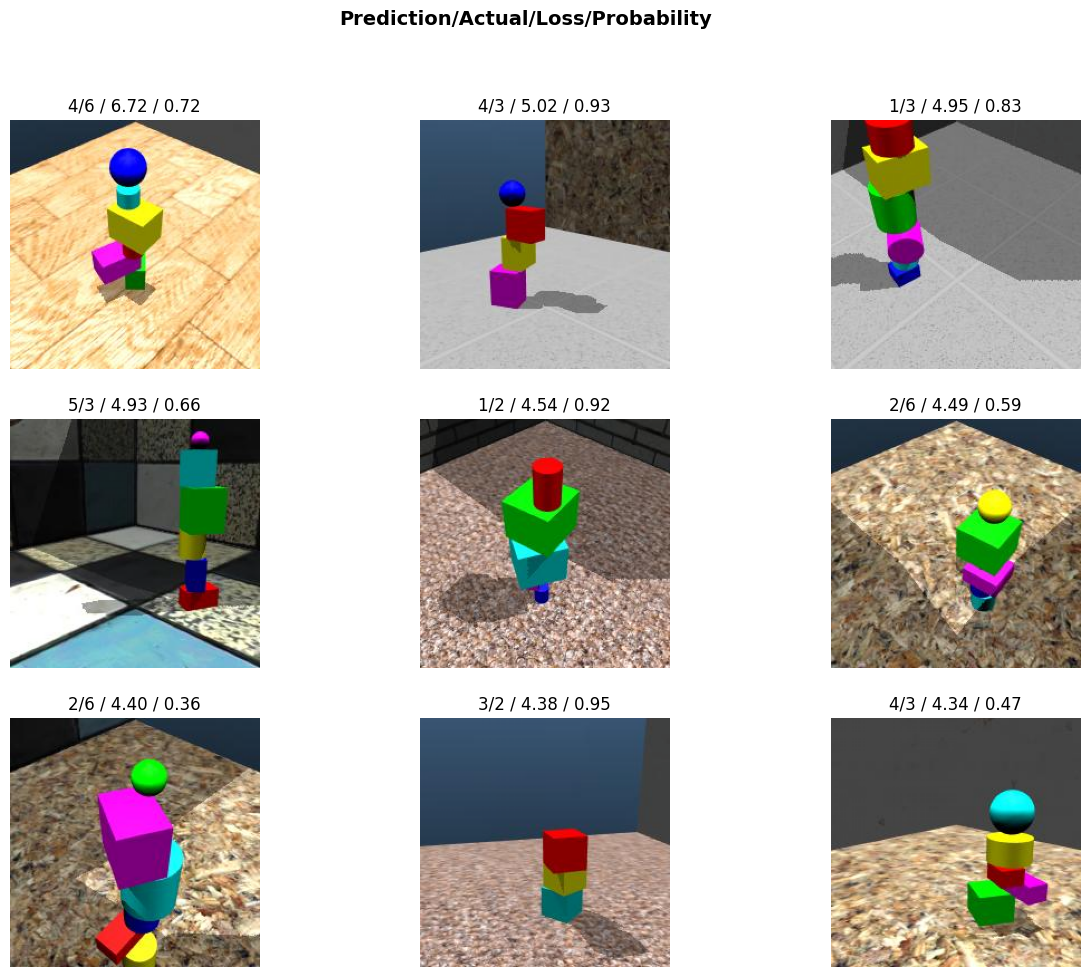

In [17]:
# Calculates the loss for certain images and visualizes them

interp = ClassificationInterpretation.from_learner(learner)
data = learner.dls
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))